## Telecom Customer Churn prediction model



problem statement

goal

null and alternative hypothesis

analytical questions

project timelines


Overview
Customer churn is a major problem and one of the most important concerns for large companies. 
Due to the direct effect on the revenues of the companies, especially in the telecom field, companies are seeking to develop means to predict potential customer to churn.
Therefore, finding factors that increase customer churn is important to take necessary actions to reduce this churn. The main contribution of our work is to develop a churn prediction model which assists telecom operators to predict customers who are most likely subject to churn. The model developed in this work uses machine learning techniques on big data platform and builds a new way of features’ engineering and selection.Customer retention and customer satisfaction are essential for a business to succeed. Customer satisfaction is improved by repeating businesses, brand loyalty, and positive word of mouth.Consumers prefer to stay with their current providers due to quality and price. Therefore, new anti-churn strategies must be constantly developed. Data processing automates analytical model building. Machine learning algorithms improve the dataset iteratively to find hidden patterns. Several studies show that machine learning can predict churn and severe problems in competitive service sectors. Predicting churning customers early on can be a valuable revenue source. 



Null hypothesis :

    1.There's a significant difference in the average monthly charges between churners and non-churners.


    Alternative hypothesis:

    1.There is no significant difference in the average monthly charges between churners and non-churners.
   
   ### Analytical questions
 
    1.What is the total churn rate?
    2.How does the different boolean attributes affect the churn?
    3.How does the different non-boolean attributes affect the churn?
    4.How does the different numerical attributes affect the churn?
    5. How does tenure affect the churn?
    6.How does the type of internet service affect churn?
    7.How does the type of contract affect the churn?
    8.How does the type of payment method affect the churn?



In [600]:
import pyodbc
from dotenv import dotenv_values  #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings
import io
import requests
import numpy as np
 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,RobustScaler,MinMaxScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


warnings.filterwarnings('ignore')

In [601]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")



In [602]:
#creating a connection sring to the SQL  database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [603]:
#creating a connection
connection = pyodbc.connect(connection_string)

In [604]:
#loading the first data set from the database
query = "Select * from dbo.LP2_Telco_churn_first_3000"

data1 = pd.read_sql(query, connection)

In [605]:
# the first five rows of the first dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [606]:
# description of the data 
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [607]:
#missing values
data1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [608]:
# the data set column numbers and rows
data1.shape

(3000, 21)

In [609]:
# showing if there are duplicates
data1.duplicated().sum()

0

In [610]:
#filling the churn missing value. The churn column has one missing value. Therefore decided to fill with false which is the most frequent entry  data1['Churn'].fillna(False)
data1['Churn'].fillna(False, inplace=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


Observations of the first data:
-the data has missing values
-the dataset has 3000 rows and 21columns
-there are no duplicates

In [611]:
#loading the second data set from GitHub repository
url = 'https://raw.github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'
download = requests.get(url).content
data2 = pd.read_csv(io.StringIO(download.decode('utf-8')))
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [612]:
# view of the data information, no missing data here
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


# Observations for data2:
-there is no missing values
-the totalcharge column is an object instead of a float
-the dataset has 2043 rows and 21 columns


## Cleaning the training datasets
-Firstly replaced the NaN values in the total charges column in data2 then change the data type from object to float

-then concantinate the dataset

In [613]:
def replace_nan_and_convert_to_float(df, column_name):
    """
    Replaces NaN values with zero and converts the column type to float for a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to process.
    - column_name (str): The name of the column to process.
    
    Returns:
    - pd.DataFrame: DataFrame with NaN values replaced and specified column converted to float.
    """
    # Convert column to numeric, setting errors='coerce' to convert non-numeric values to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Replace NaN values with 0
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    return df


df = pd.DataFrame(data2)

# Process the 'TotalCharges' column: replace NaN with zero and convert to float
df = replace_nan_and_convert_to_float(df, 'TotalCharges')

print("\nDataFrame after processing")
clean_data2=df
clean_data2.head()



DataFrame after processing


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [614]:
#concating the two data sets after doing the cleaning i.e changing the total charges datatype and filling the missing value in churn column in data1
training_data = pd.concat([data1, clean_data2], axis=0,ignore_index=True)
training_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [615]:
# this is the training data info after concatinating
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


## EDA

In [616]:
#Summary statistics of numerical columns
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002
TotalCharges,5038.0,2300.692041,2269.502705,0.0,417.125,1400.699988,3860.599976,8670.100000


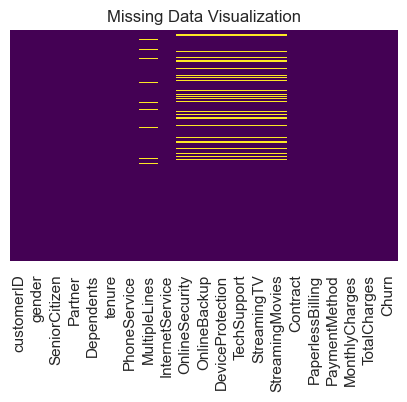

Missing Values Summary:
 customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 0
dtype: int64


In [617]:
#Visualizing the missing values of the training data
# Check for missing values
missing_values=training_data.isnull().sum()
#missing_values
# Visualize missing data
plt.figure(figsize=(5, 3))
sns.heatmap(training_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Data Visualization')
plt.show()

# Display missing values summary
print("Missing Values Summary:\n", missing_values)

In [618]:
#checking on duplicates on the training data
training_data.duplicated().sum()

0

In [619]:
# since the churn column is the predicted column convert it to  a boolean from object

def convert_to_yes_no(df, columns):
    """
    Converts multiple columns with mixed values (True, False, Yes, No) to only Yes and No.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the columns to be converted.
    - columns (list of str): List of column names to convert.
    
    Returns:
    - pd.DataFrame: DataFrame with the specified columns converted to Yes and No.
    """
    # Define a mapping from original to desired values
    conversion_map = {
        True: 'Yes',
        'True': 'Yes',
        False: 'No',
        'False': 'No',
        'Yes': 'Yes',
        'No': 'No',
        'yes': 'Yes',  # Handling lowercase input
        'no': 'No',    # Handling lowercase input
        'YES': 'Yes',  # Handling uppercase input
        'NO': 'No'     # Handling uppercase input
    }
    
    # Apply the mapping to each specified column
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(conversion_map)
    
    return df

# Assuming 'training_data' is your DataFrame and already defined
# Example column names to be converted
columns_to_convert = ['Churn','Partner', 'Dependents', 'PhoneService']

# Convert specified columns to only contain Yes and No
df = convert_to_yes_no(training_data, columns_to_convert)

print("\nDataFrame after prepocessing")
clean_train_data=df

clean_train_data.head()


DataFrame after prepocessing


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,0,No,No,34,Yes,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,0,No,No,2,Yes,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,0,No,No,45,No,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,0,No,No,2,Yes,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,Yes


In [620]:
# converting the monthlycharges and total charges column to int data type
df = pd.DataFrame(clean_train_data)

# Fill NaN values with a default value, for example, 0
df['TotalCharges'].fillna(0, inplace=True)

# Convert columns from float to int
df['MonthlyCharges'] = df['MonthlyCharges'].astype(int)
df['TotalCharges'] = df['TotalCharges'].astype(int)

# Display the DataFrame after conversion
print("\nDataFrame after converting float to int:")
Clean_train_data=df



DataFrame after converting float to int:


In [621]:
# Drop the 'customerID' column from the DataFrame becausing during the training stage encoding the column is challenging
clean_training_data = Clean_train_data.drop('customerID', axis=1)

# Display the DataFrame after dropping the column
print("\nDataFrame after dropping the 'customerID' column:")
print(clean_training_data.head())



DataFrame after dropping the 'customerID' column:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0          None             DSL          False         True            False   
1         False             DSL           True        False             True   
2         False             DSL           True         True            False   
3          None             DSL           True        False             True   
4         False     Fiber optic          False        False            False   

  TechSupport StreamingTV StreamingMovies        Contract P

In [622]:

clean_training_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29,29,No
1,Male,0,No,No,34,Yes,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56,1889,No
2,Male,0,No,No,2,Yes,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53,108,Yes
3,Male,0,No,No,45,No,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42,1840,No
4,Female,0,No,No,2,Yes,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70,151,Yes


In [623]:
clean_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            5043 non-null   object
 1   SeniorCitizen     5043 non-null   int64 
 2   Partner           5043 non-null   object
 3   Dependents        5043 non-null   object
 4   tenure            5043 non-null   int64 
 5   PhoneService      5043 non-null   object
 6   MultipleLines     4774 non-null   object
 7   InternetService   5043 non-null   object
 8   OnlineSecurity    4392 non-null   object
 9   OnlineBackup      4392 non-null   object
 10  DeviceProtection  4392 non-null   object
 11  TechSupport       4392 non-null   object
 12  StreamingTV       4392 non-null   object
 13  StreamingMovies   4392 non-null   object
 14  Contract          5043 non-null   object
 15  PaperlessBilling  5043 non-null   object
 16  PaymentMethod     5043 non-null   object
 17  MonthlyCharges

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

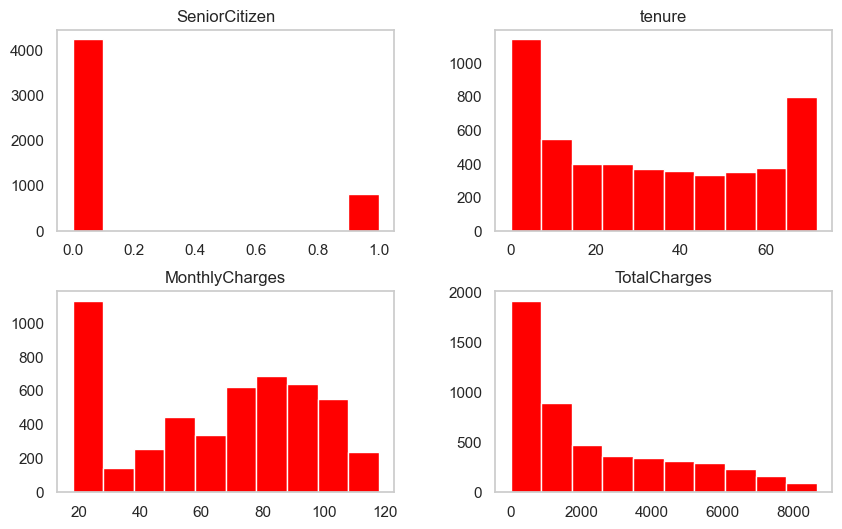

In [624]:
# numerical column visual representation using histogram
clean_training_data.hist(figsize=(10,6),grid=False, color='red')

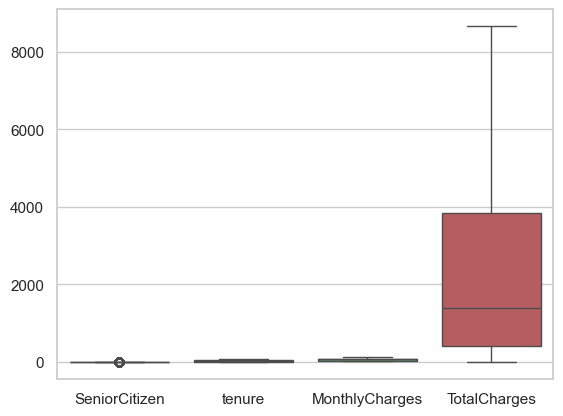

In [625]:
#checking outliers
sns.boxplot(clean_training_data, orient='v')
plt.show()


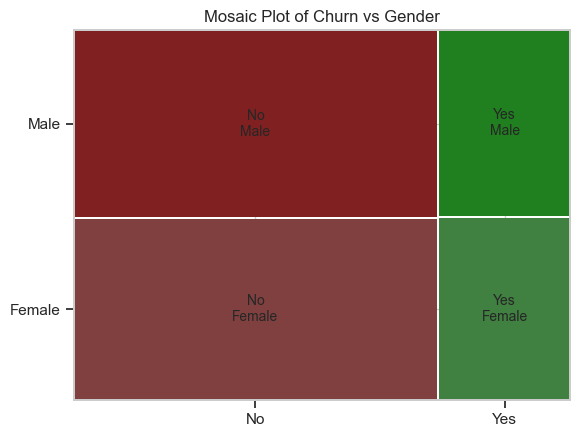

In [626]:
mosaic(clean_training_data, ['Churn', 'gender'], title='Mosaic Plot of Churn vs Gender')
plt.show()

If the tiles for churn and non-churn are of similar size within each gender category, it suggests that churn rates are similar across genders.
If there's a noticeable difference in tile sizes between genders, it suggests that churn rates differ significantly between male and female customers.
If the tile for churn is much larger than the tile for non-churn within a gender category, it indicates a higher churn rate for that gender.
Conversely, if the tile for non-churn is much larger, it indicates a lower churn rate for that gender.

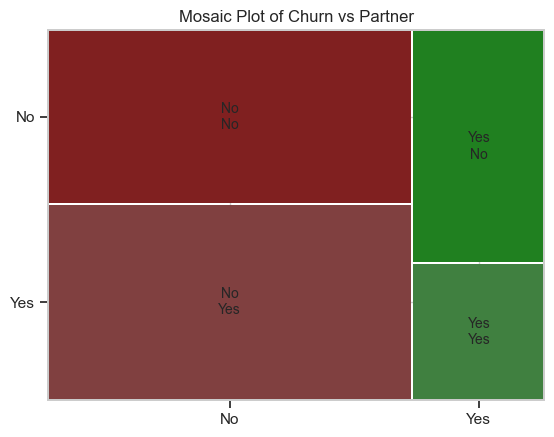

In [627]:
mosaic(clean_training_data, ['Churn', 'Partner'], title='Mosaic Plot of Churn vs Partner')
plt.show()

In [628]:
#skewness
categorical_columns=clean_training_data.select_dtypes('object').columns
clean_training_data.drop(categorical_columns,axis=1).skew()

SeniorCitizen     1.831228
tenure            0.225132
MonthlyCharges   -0.238125
TotalCharges      0.945708
dtype: float64

In [629]:
#the skewness of numeric data in the dataset is
clean_training_data.drop(categorical_columns,axis=1).skew().sum()

2.763943358286752

In [630]:
categorical_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [631]:
numerical_columns=clean_training_data.select_dtypes('number').columns
numerical_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [632]:
correlation=clean_training_data[numerical_columns].corr()
correlation

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.004597,0.221752,0.095830
tenure,0.004597,1.000000,0.240686,0.826570
MonthlyCharges,0.221752,0.240686,1.000000,0.647022
TotalCharges,0.095830,0.826570,0.647022,1.000000


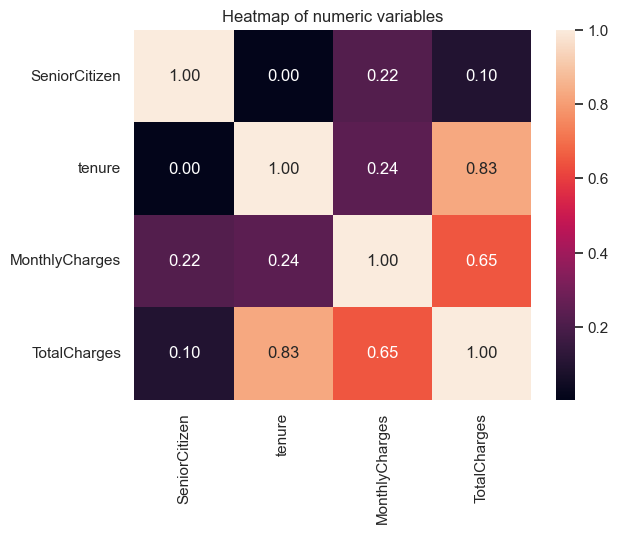

In [633]:
sns.heatmap(correlation,annot=True,fmt='.2f')
plt.title('Heatmap of numeric variables',fontsize=12)
plt.show()

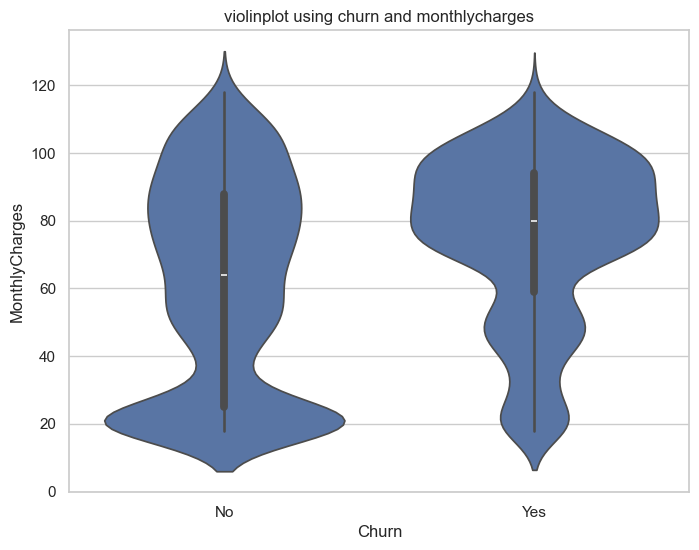

In [634]:
plt.figure(figsize=(8,6))
sns.violinplot(data=clean_training_data,x='Churn',y='MonthlyCharges')
plt.title('violinplot using churn and monthlycharges',fontsize=12)
plt.show()

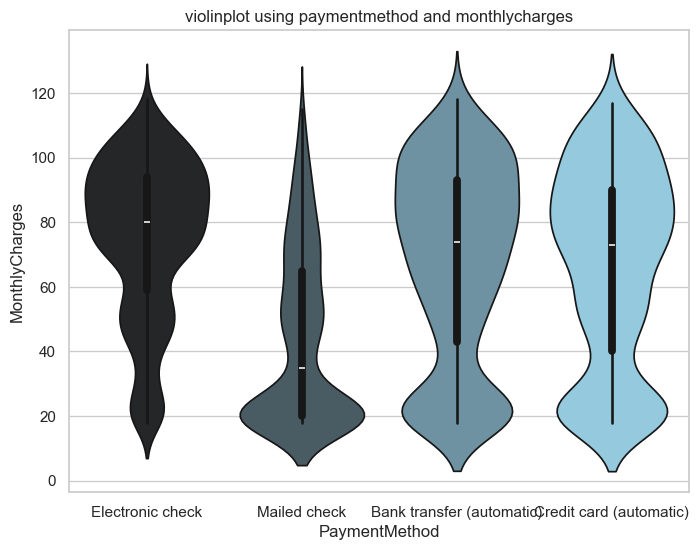

In [635]:
plt.figure(figsize=(8,6))
sns.violinplot(data=clean_training_data,x='PaymentMethod',y='MonthlyCharges',hue='PaymentMethod',palette='dark:skyblue')
plt.title('violinplot using paymentmethod and monthlycharges',fontsize=12)
plt.show()

most people who left their monthly charges was above 80

# Hypothesis testing

In [636]:
# Filter the dataset for churners and non-churners
churners = clean_training_data[clean_training_data['Churn'] == 'Yes']
non_churners = clean_training_data[clean_training_data['Churn'] =='No']

# Extract monthly charges for churners and non-churners
churner_monthly_charges = churners['MonthlyCharges']
non_churner_monthly_charges = non_churners['MonthlyCharges']

# Perform t-test for independent samples
t_statistic, p_value = stats.ttest_ind(churner_monthly_charges, non_churner_monthly_charges)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Determine significance level
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in average monthly charges between churners and non-churners.")

T-statistic: 14.658713057474307
P-value: 1.1215929876743236e-47
Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.


## Answer analytical questions

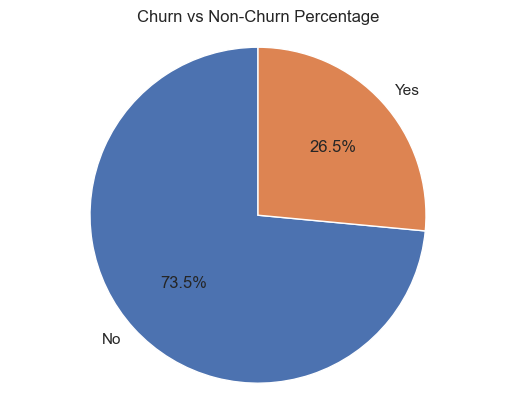

In [637]:
## 1. What is the total churn rate

def calculate_churn_percentage(df, column_name):
    """
    Calculate the percentage of churn and non-churn in a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - column_name (str): The column name where churn data is stored.
    
    Returns:
    - dict: Dictionary containing the percentage of churn and non-churn.
    """
    # Calculate the frequency of each category in the specified column
    counts = df['Churn'].value_counts(normalize=True)
    
    # Convert the frequencies to percentage
    percentages = counts * 100
    
    return percentages

def plot_churn_pie_chart(percentages):
    """
    Plots a pie chart of churn and non-churn percentages.
    
    Parameters:
    - percentages (pd.Series): Series containing the percentages of churn and non-churn.
    """
    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Title
    plt.title('Churn vs Non-Churn Percentage')

    # Show the plot
    plt.show()

# Example usage with a sample DataFrame
#data = {'CustomerID': [1, 2, 3, 4, 5, 6, 7, 8], 'Churn': ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No']}
df = pd.DataFrame(clean_training_data)

# Calculate churn and non-churn percentages
churn_percentages = calculate_churn_percentage(df, 'Churn')

# Plot the pie chart
plot_churn_pie_chart(churn_percentages)

## 2. How does the different boolean attribute affect the churn

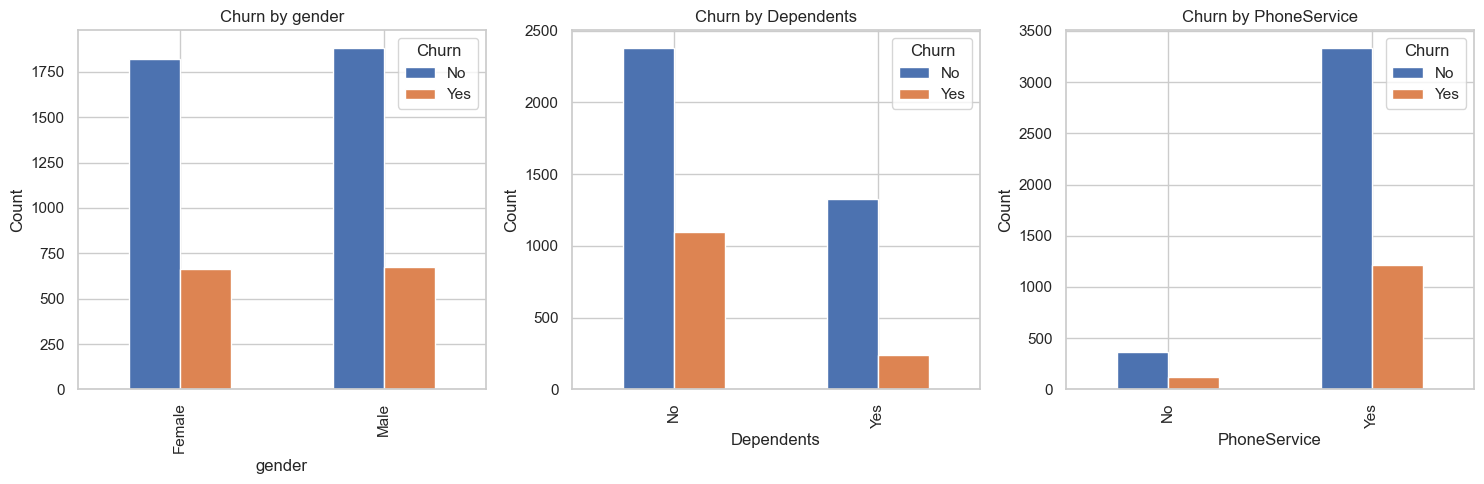

In [638]:
# How does gender, partner and phone service affect churn
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, feature in zip(axes, ['gender', 'Dependents', 'PhoneService']):
    df.groupby([feature, 'Churn']).size().unstack().plot(kind='bar', ax=ax, title=f'Churn by {feature}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. How does the different non-boolean affect churn e.g Contract,PaymentMethod,

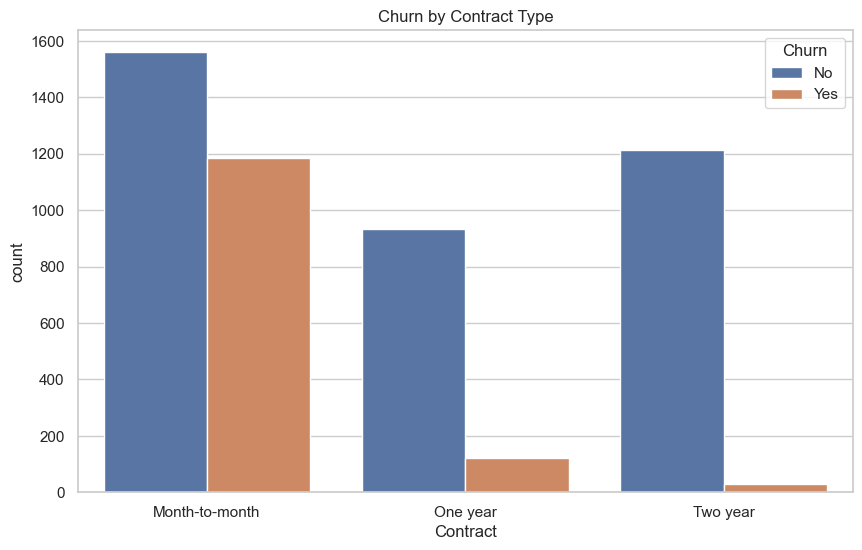

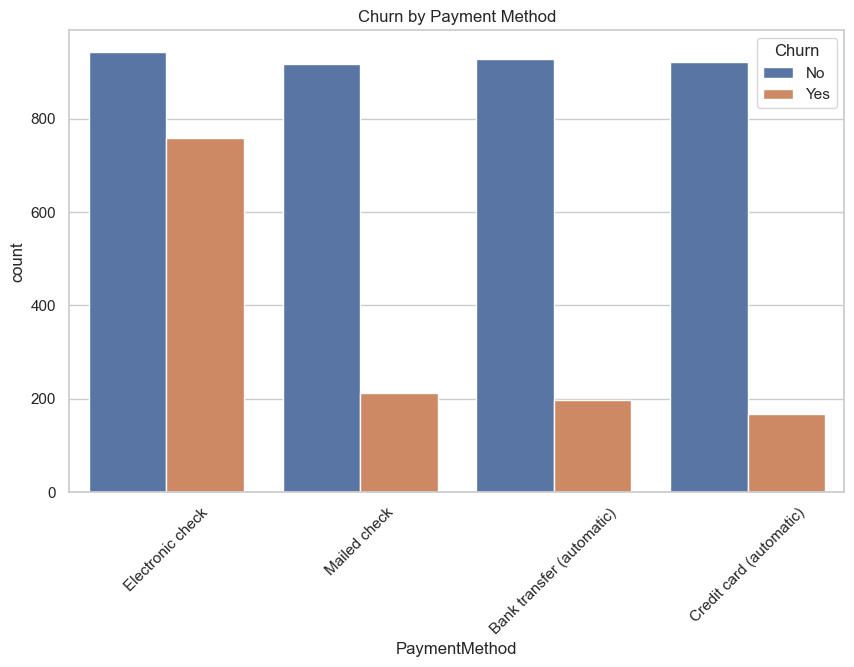

In [639]:
# Setting up the visualization environment
sns.set(style="whitegrid")

# Bar plot for Contract vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=clean_training_data)
plt.title('Churn by Contract Type')
plt.show()

# Clustered bar plot for Payment Method vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=clean_training_data)
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

## 4 How does monthly charges and total charges affect churn

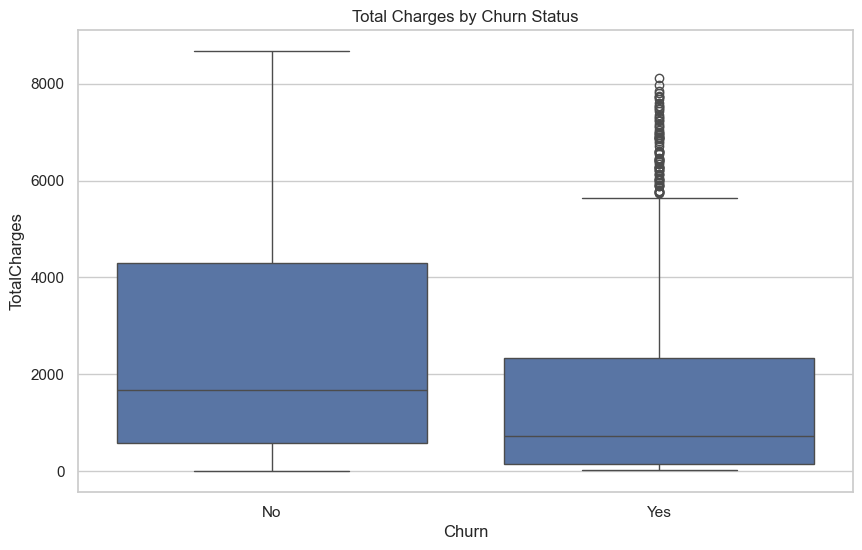

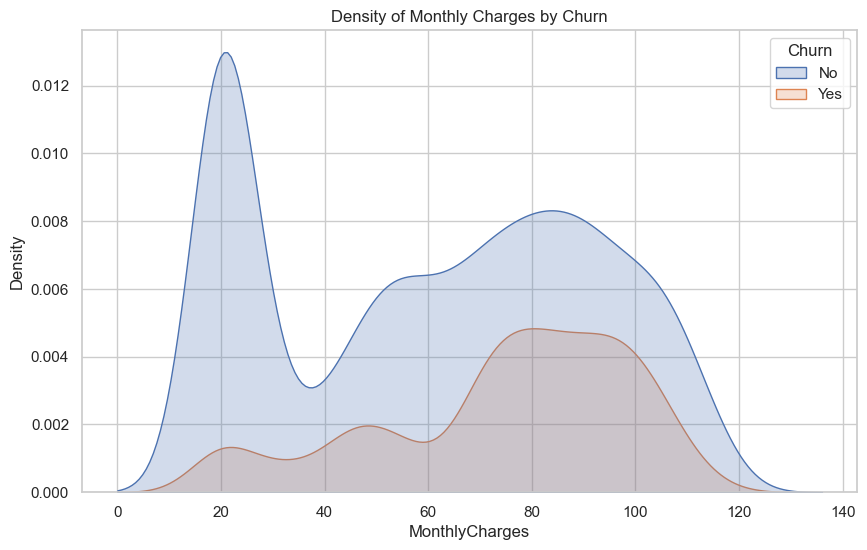

In [640]:
# Setting up the visualization environment
sns.set(style="whitegrid")


# Box Plot for Total Charges by Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=clean_training_data)
plt.title('Total Charges by Churn Status')
plt.show()

# Density Plot for Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=clean_training_data, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Density of Monthly Charges by Churn')
plt.show()

## 5. How does the type of internet service affect the churn

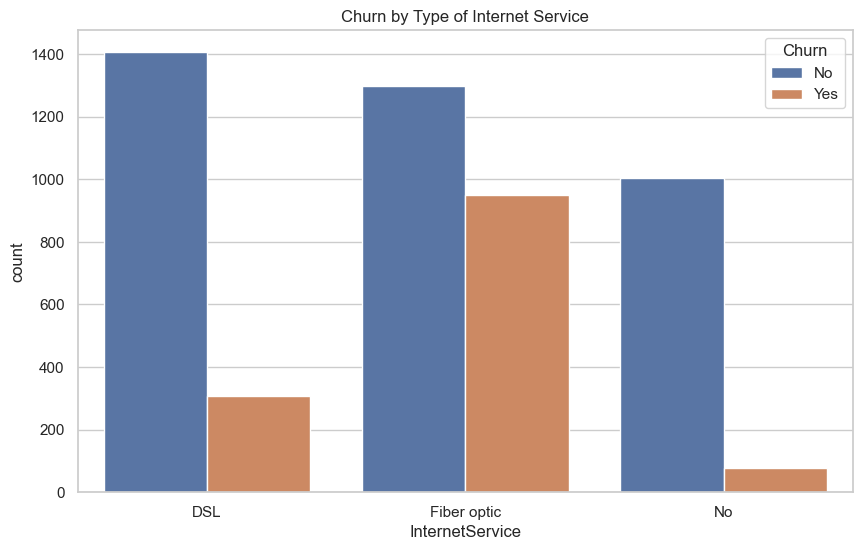

In [641]:
# Count Plot for Internet Service vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=clean_training_data)
plt.title('Churn by Type of Internet Service')
plt.show()

## Data Preparation

In [642]:
# data description
clean_training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.0,0.0,0.0,1.0
tenure,5043.0,32.576641,24.529807,0.0,9.0,29.0,56.0,72.0
MonthlyCharges,5043.0,64.624033,30.074234,18.0,35.0,70.0,90.0,118.0
TotalCharges,5043.0,2297.943089,2269.530274,0.0,415.0,1398.0,3857.5,8670.0


In [643]:
# Checking if data is balanced
#main concern is preddicting the churn percentage.Y=churn.So we will be checking if churn is balanced
#X=input data
#Y=label(what is to be predicted by the model)
X=clean_training_data.drop('Churn',axis=1)
Y=clean_training_data['Churn']

In [644]:
# visualizing the input data without the Y(churn column)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29,29
1,Male,0,No,No,34,Yes,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56,1889
2,Male,0,No,No,2,Yes,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53,108
3,Male,0,No,No,45,No,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42,1840
4,Female,0,No,No,2,Yes,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70,151


In [645]:
#illustrating the count of churners and non-churners
class_distro=clean_training_data['Churn'].value_counts().rename('Total').reset_index()
class_distro

,Churn,Total
0,No,3707
1,Yes,1336


In [646]:
#Getting the ratio distribution of the churn and the non-churners
class_distro['Ratio']=class_distro['Total'].apply(lambda X:round(X/class_distro['Total'].sum()*100),2)
class_distro['Ratio']

0    74
1    26
Name: Ratio, dtype: int64

In [647]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [648]:
#showing the first column of the x_train split data
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2175,Female,0,No,No,30,Yes,False,Fiber optic,False,False,False,True,True,False,Month-to-month,False,Electronic check,85,2555
4022,Female,0,No,No,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),18,347
1460,Male,0,No,No,5,Yes,True,Fiber optic,False,True,True,False,False,False,Month-to-month,True,Electronic check,85,424
2322,Female,0,No,Yes,49,Yes,False,No,None,None,None,None,None,None,Two year,False,Credit card (automatic),20,1024
2349,Male,0,Yes,Yes,72,Yes,True,Fiber optic,False,True,True,True,False,False,Two year,False,Bank transfer (automatic),90,6565


In [649]:
#Encoding the Y-values.because alot of ML models are algorithimic and understand numbers
encoder=LabelEncoder()

Y_train_encoded=encoder.fit_transform(Y_train)
Y_test_encoded=encoder.transform(Y_test)


## Prepare Pipelines

pipelines are used to perform a series of steps.And since the data has both numeric and categorical values. We will do pipelines fror categorical columns and numerical columns

In [650]:
categorical_columns=X.select_dtypes('object').columns
categorical_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [651]:
numeric_columns=X.select_dtypes('number').columns
numeric_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [652]:
minmax_scaler = MinMaxScaler()

minmax_scaled =minmax_scaler.fit_transform(X.select_dtypes('number'))
minmax_scaled_df=pd.DataFrame(minmax_scaled,columns=X.select_dtypes('number').columns)
minmax_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000000,0.000000,0.000000,1.0
tenure,5043.0,0.452453,0.340692,0.0,0.125000,0.402778,0.777778,1.0
MonthlyCharges,5043.0,0.466240,0.300742,0.0,0.170000,0.520000,0.720000,1.0
TotalCharges,5043.0,0.265045,0.261768,0.0,0.047866,0.161246,0.444925,1.0


<Axes: ylabel='Density'>

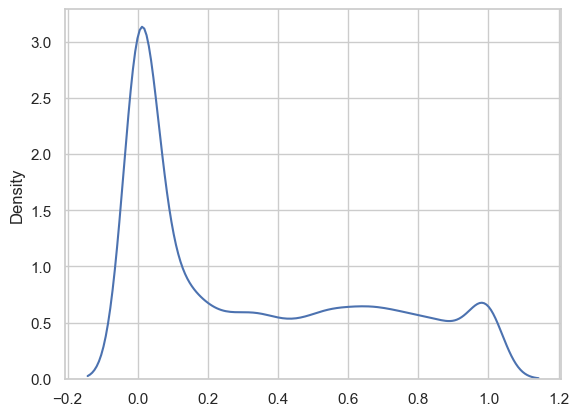

In [653]:
sns.kdeplot(minmax_scaled_df.values.ravel())

In [654]:
robust_scaler = RobustScaler()

r_scaled =robust_scaler.fit_transform(X.select_dtypes('number'))
r_scaled_df=pd.DataFrame(r_scaled,columns=X.select_dtypes('number').columns)
r_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.0,0.000000,1.000000
tenure,5043.0,0.076099,0.521911,-0.617021,-0.425532,0.0,0.574468,0.914894
MonthlyCharges,5043.0,-0.097745,0.546804,-0.945455,-0.636364,0.0,0.363636,0.872727
TotalCharges,5043.0,0.261421,0.659268,-0.406100,-0.285548,0.0,0.714452,2.112418


<Axes: ylabel='Density'>

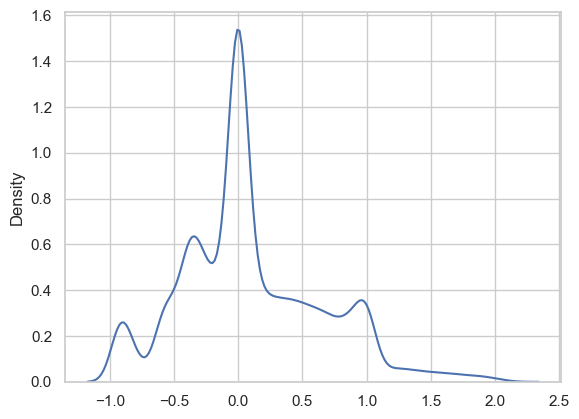

In [655]:
sns.kdeplot(r_scaled_df.values.ravel())

In [656]:
standard_scaler = StandardScaler()

s_scaled =standard_scaler.fit_transform(X.select_dtypes('number'))
s_scaled_df=pd.DataFrame(s_scaled,columns=X.select_dtypes('number').columns)
s_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,-3.170179e-17,1.000099,-0.440332,-0.440332,-0.440332,-0.440332,2.271015
tenure,5043.0,-3.522421e-18,1.000099,-1.328175,-0.961238,-0.145822,0.954988,1.607321
MonthlyCharges,5043.0,-1.831659e-16,1.000099,-1.550452,-0.985128,0.178774,0.843861,1.774983
TotalCharges,5043.0,-2.448082e-17,1.000099,-1.012620,-0.829744,-0.396572,0.687240,2.807933


<Axes: ylabel='Density'>

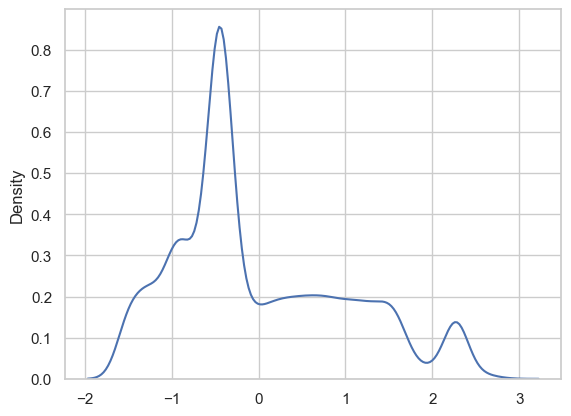

In [657]:
sns.kdeplot(s_scaled_df.values.ravel())

In [658]:
# Step 1: Fill missing values with a placeholder string
X_train = X_train.fillna('missing')

# Step 2: Convert all categorical data to strings (especially if they are booleans)
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or X_train[col].dtype == 'bool']
X_train[categorical_cols] = X_train[categorical_cols].astype(str)

# Optional: Check data types
print(X_train.dtypes)

gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges       int32
TotalCharges         int32
dtype: object


In [659]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int']).columns.tolist()

In [668]:
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),  # Filling missing values
    ('scaler', RobustScaler()),                        # Scale data
    ('log_transformer', FunctionTransformer(np.log1p)) # Log transformation
])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))                       # Use OneHotEncoder for categorical features
])

preprocessor = ColumnTransformer(transformers=[
   ('num_pipeline', numeric_transformer, numeric_features),
   ('cat_pipeline', categorical_transformer,categorical_features )
])


    

                          

In [669]:
# Models setup
models = [
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5))
]

# Dictionary to hold all pipelines
all_Pipeline = {}

# Creating and storing each model's pipeline
for model_name, classifier in models:
    final_Pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Fit the pipeline (Assuming X_train and Y_train_encoded are defined)
    final_Pipeline.fit(X_train, Y_train_encoded)

    # Store in the dictionary
    all_Pipeline[model_name] = final_Pipeline

In [ ]:
#Step 3: Reset Indexes
#After manipulation, especially if rows are filtered or dropped, reset the indexes of your DataFrames to ensure alignment:

#python
#Copy code
#X_train.reset_index(drop=True, inplace=True)
#Y_train_encoded = pd.Series(Y_train_encoded).reset_index(drop=True)

In [670]:
all_Pipeline

{'Decision_Tree': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num_pipeline',
                                                   Pipeline(steps=[('num_imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    RobustScaler()),
                                                                   ('log_transformer',
                                                                    FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                   ['SeniorCitizen', 'tenure',
                                                    'MonthlyCharges',
                                                    'TotalCharges']),
                                                  ('cat_pipeline',
                                              

In [671]:
all_Pipeline['Decision_Tree']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('log_transformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImp...requent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [672]:
#Evaluation
Y_pred = final_Pipeline.predict(X_test)

In [675]:
metrics=classification_report(Y_test,Y_pred)
print(metrics)
print(model_name)
print('='*50)

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['No' 'Yes'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.